# Smith chart domains

`pysmithchart` can plot several different *domains* on the same Smith chart projection.
The domain determines what you pass to `ax.plot()` / `ax.scatter()` / `ax.text()` and how the library converts that data internally for display.

This notebook explains each domain and shows small, self-contained examples.

In [1]:
%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "emscripten":
    import piplite

    await piplite.install("pysmithchart")

import pysmithchart
from pysmithchart import Z_DOMAIN, Y_DOMAIN, R_DOMAIN, NORM_Z_DOMAIN, NORM_Y_DOMAIN
from pysmithchart import utils

text_box = dict(facecolor="lightyellow")

## Domain quick reference

The Smith chart itself is drawn in terms of **normalized impedance**

$$
z = \frac{Z}{Z_0} = r + jx
$$

but users naturally work with different quantities (ohms, siemens, reflection coefficient).
`pysmithchart` supports these through a `domain=` choice.

| Domain constant | What you pass to plotting calls | Internal conversion | Typical use |
|---|---|---|---|
| `Z_DOMAIN` (default) | $Z$ in ohms | $z = Z/Z_0$ | Most RF matching, measured impedances |
| `NORM_Z_DOMAIN` | $z$ normalized (dimensionless) | use as-is | data matches impedance grid |
| `R_DOMAIN` | $\Gamma$ (a.k.a. S11), complex | $z = (1+\Gamma)/(1-\Gamma)$ | VNAs / S-parameter workflows |
| `Y_DOMAIN` | $Y$ in siemens | $z = \frac{1}{Y Z_0}$ | Admittance-based matching, dual networks |
| `NORM_Y_DOMAIN` | $y$ normalized (dimensionless) | use as-is | data matches admittance grid |

Domains let you supply the quantity you naturally have: $Z$, $z$, $Y$, or $\Gamma$.

## How to set the domain

You can reset the default domain for all subsequent plots on an axis:

```python
ax = plt.subplot(111, projection="smith", domain=NORM_Z_DOMAIN)
```

or per plotting call (overrides the default):

```python
ax.plot(Γ, domain=R_DOMAIN)
ax.text(z.real, z.imag, "label", domain=Z_DOMAIN)
```

## A single physical load shown four ways

We will use the same physical load, and plot it using each domain.

- Reference impedance: `Z0 = 50 Ω`
- Load impedance: `ZL = 25 + j25 Ω`

From these we can compute:
- normalized impedance: `z = ZL / Z0`
- admittance: `Y = 1 / ZL`
- reflection coefficient: `Γ = (ZL - Z0) / (ZL + Z0)`

In [2]:
Z0 = 50
ZL = 30 + 1j * 30

z_norm = ZL / Z0
Y = 1 / ZL
Gamma = utils.calc_gamma(Z0, ZL)

print("ZL =", ZL)
print("z  =", z_norm)
print("Y  =", utils.cs(Y, 3))
print("Γ  =", utils.cs(Gamma, 3))

ZL = (30+30j)
z  = (0.6+0.6j)
Y  =  0.017 -  0.017j
Γ  = -0.096 +  0.411j


### 1) `Z_DOMAIN`: pass **ohms**

This is the default domain. You pass `Z` in ohms; `pysmithchart` divides by `Z0` internally.

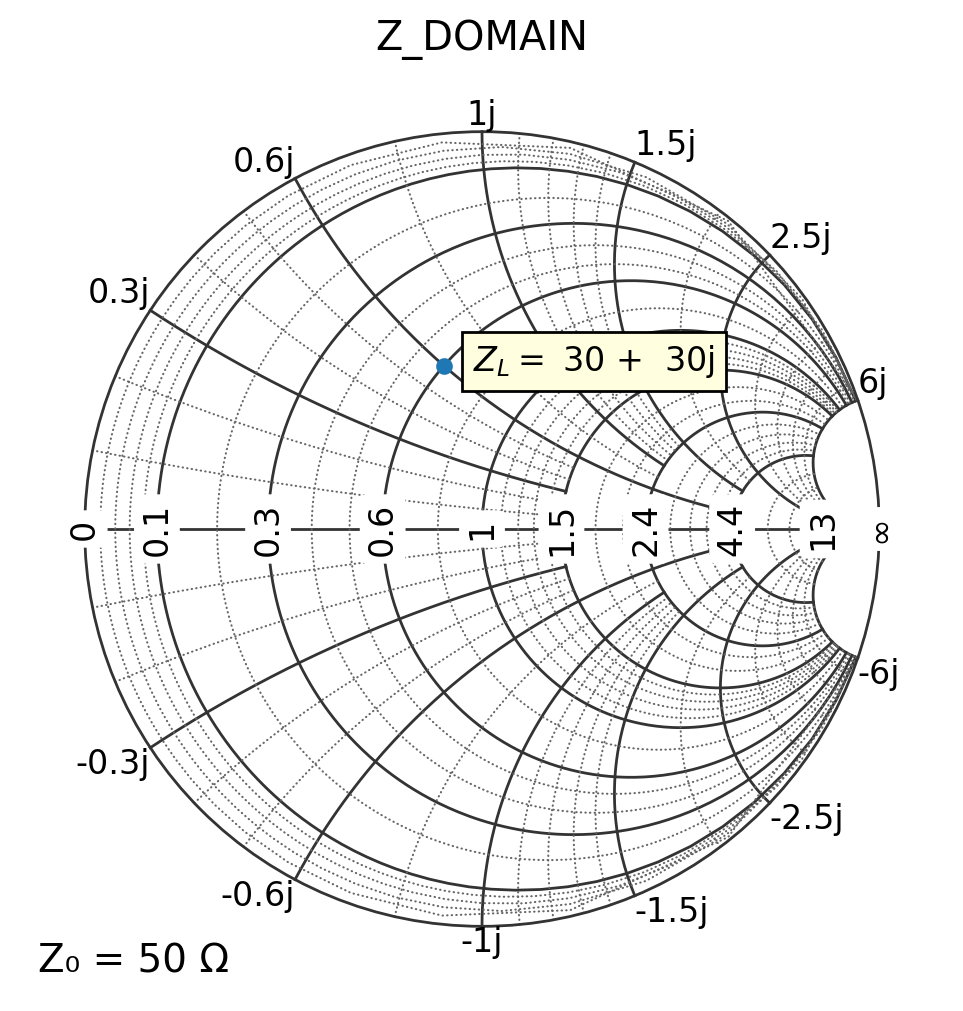

In [3]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", Z0=Z0)

ax.plot(ZL, marker="o", linestyle="")
text_offset = 5 + 3j
ax.text(ZL + text_offset, "$Z_L =$" + utils.cs(ZL, 0), bbox=text_box)

ax.set_title("Z_DOMAIN")
plt.show()

### 2) `NORM_Z_DOMAIN`: pass **normalized z** (dimensionless)

In this domain, you pass `z = Z/Z0` directly. These values should appear just where you expect them on the chart

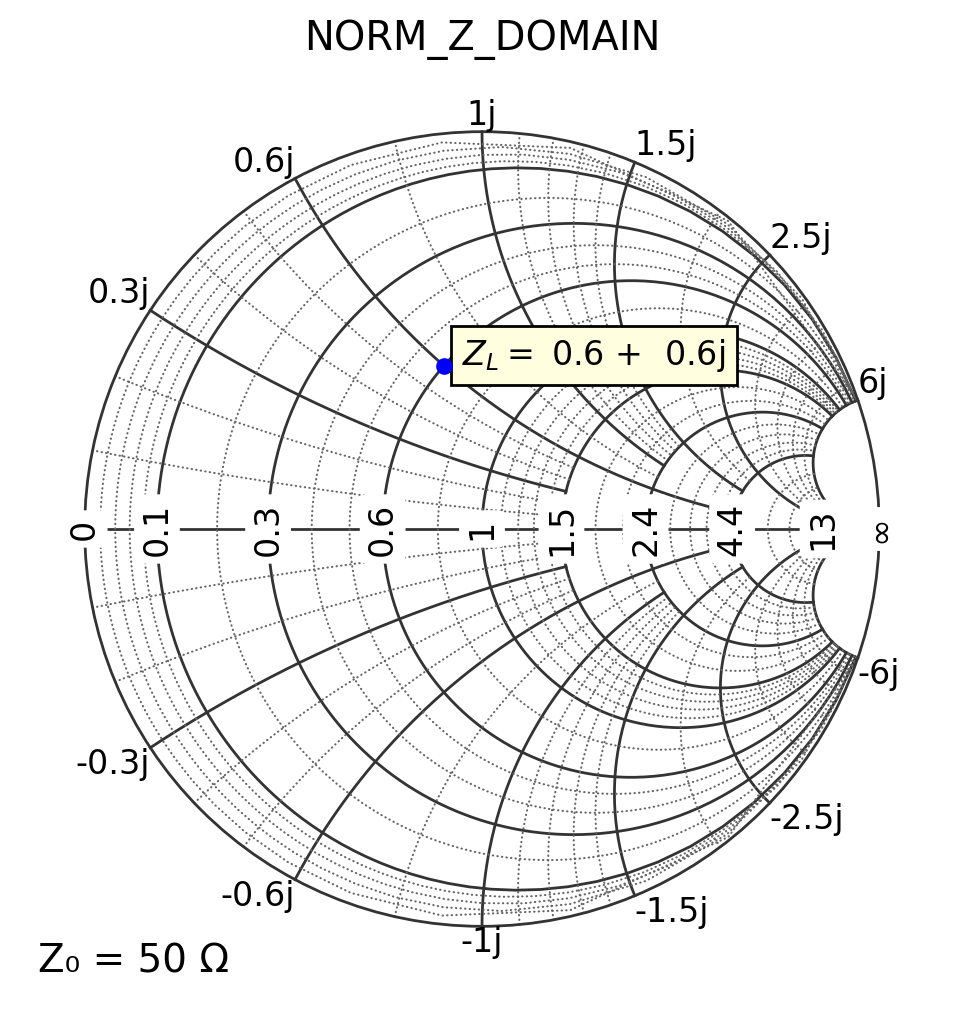

In [4]:
Z0 = 50
ZL = 30 + 1j * 30
z_norm = ZL / Z0

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=NORM_Z_DOMAIN)

ax.plot(z_norm, "bo")
text_offset = 0.05 + 0.05j
ax.text(z_norm + text_offset, "$Z_L =$" + utils.cs(z_norm, 2), bbox=text_box)

ax.set_title("NORM_Z_DOMAIN")
plt.show()

### 3) `R_DOMAIN`: pass **Γ (S11)**

If you have S-parameters from a VNA or simulator, you might start with Γ directly.  In
the `R_DOMAIN` `pysmithchart` internally converts the datapoint to normalized 
impedance using the inverse Möbius transform:
$$
z = \frac{1+\Gamma}{1-\Gamma}
$$

Only points inside the unit circle |Γ| ≤ 1 are visible on the chart.

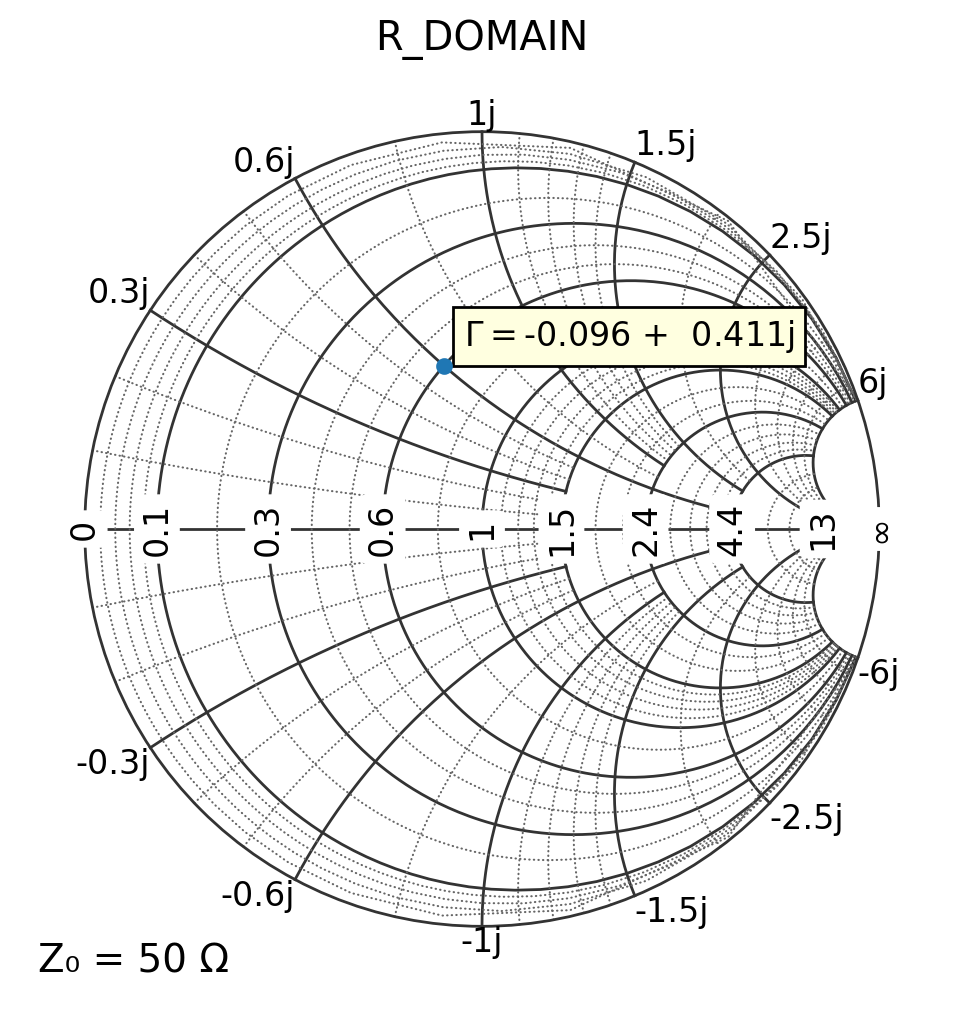

In [5]:
Z0 = 50
ZL = 30 + 1j * 30
Gamma = utils.calc_gamma(Z0, ZL)

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=R_DOMAIN)

ax.plot(Gamma, marker="o", linestyle="")
text_offset = 0.05 + 0.05j
ax.text(Gamma + text_offset, "$\Gamma =$" + utils.cs(Gamma, 3), bbox=text_box)

ax.set_title("R_DOMAIN")
plt.show()

### 4) `Y_DOMAIN`: pass **Y in siemens**

Admittance plotting is useful for “dual” matching workflows (e.g., shunt elements).

Internally, `pysmithchart` converts `Y` to normalized impedance using:
$z = \frac{1}{Y Z_0}$

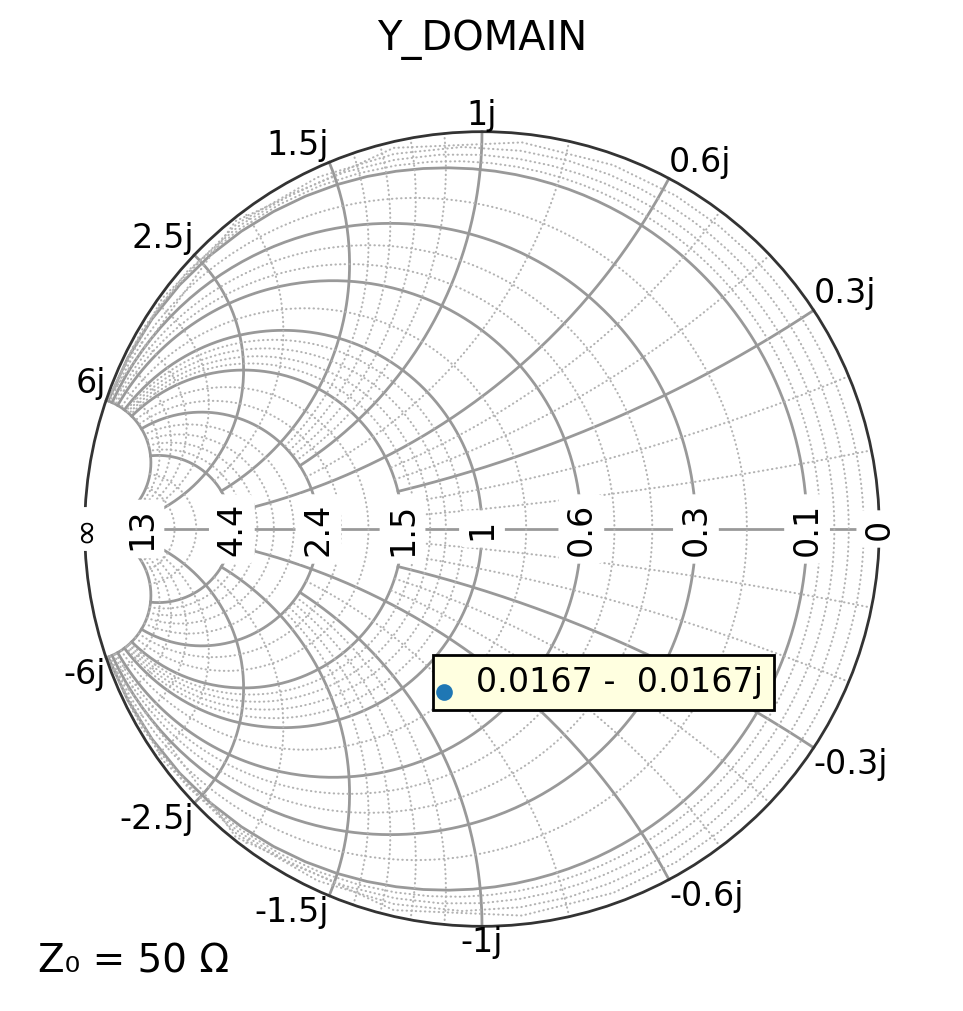

In [6]:
ZL = 30 + 1j * 30
YL = 1 / ZL

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", grid="admittance", domain=Y_DOMAIN)

ax.plot(YL, marker="o", linestyle="")
ax.text(YL, "  " + utils.cs(YL, 4), bbox=text_box)

ax.set_title("Y_DOMAIN")
plt.show()

### 5) `NORM_Y_DOMAIN`: pass normalized admittance (dimensionless)**

Admittance plotting is useful for “dual” matching workflows (e.g., shunt elements).


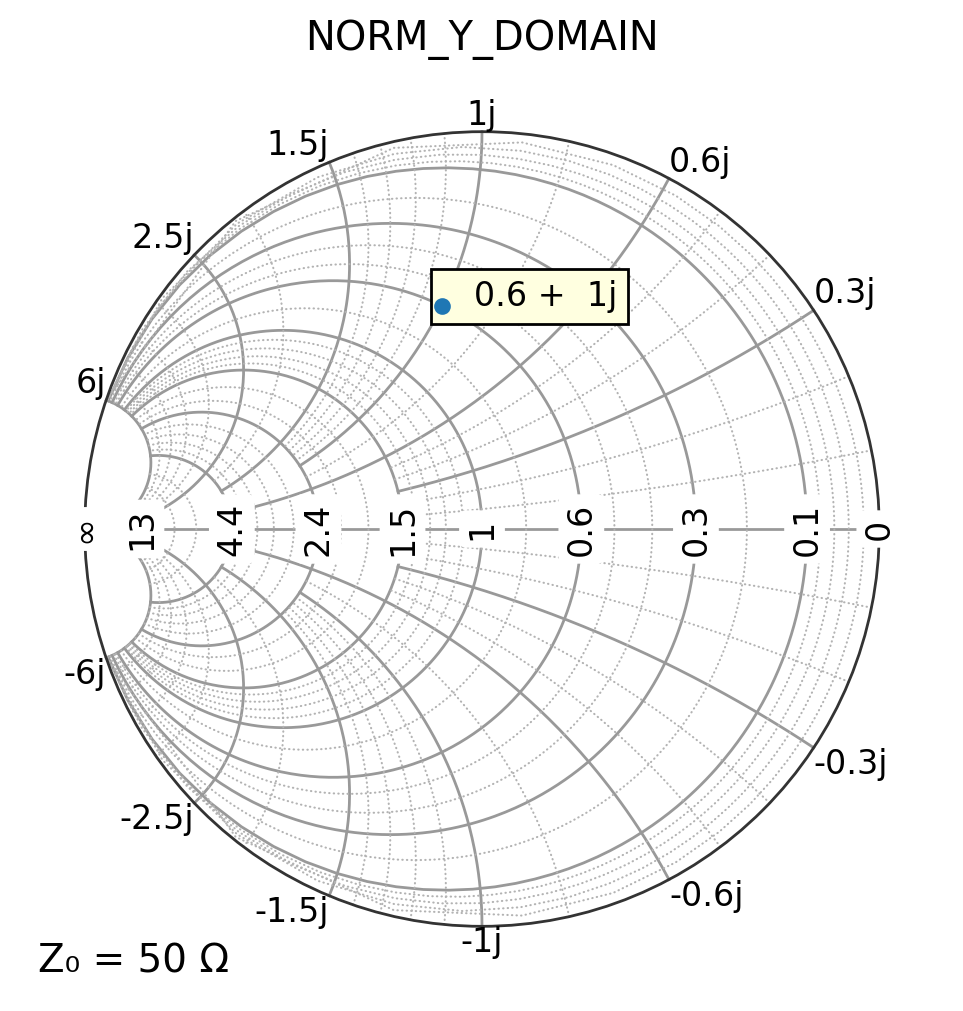

In [7]:
y = 0.6 + 1j

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", grid="admittance", domain=NORM_Y_DOMAIN)

ax.plot(y, marker="o", linestyle="")
ax.text(y, "  " + utils.cs(y, 4), bbox=text_box)

ax.set_title("NORM_Y_DOMAIN")
plt.show()

## What about `ax.text()` and `ax.annotate()`?

`pysmithchart` applies the same domain logic to `text()` and `annotate()` as it does to `plot()`.

All forms below work fine in all four domains

* `ax.text(z, label, ...)` 
* `ax.text(x, y, label, ...)`

* `ax.annotate(x, y, label, ...)`

> Note because annotate has two positions xy and xytext, you cannot use complex values with annotate

### A simple example of ax.text()

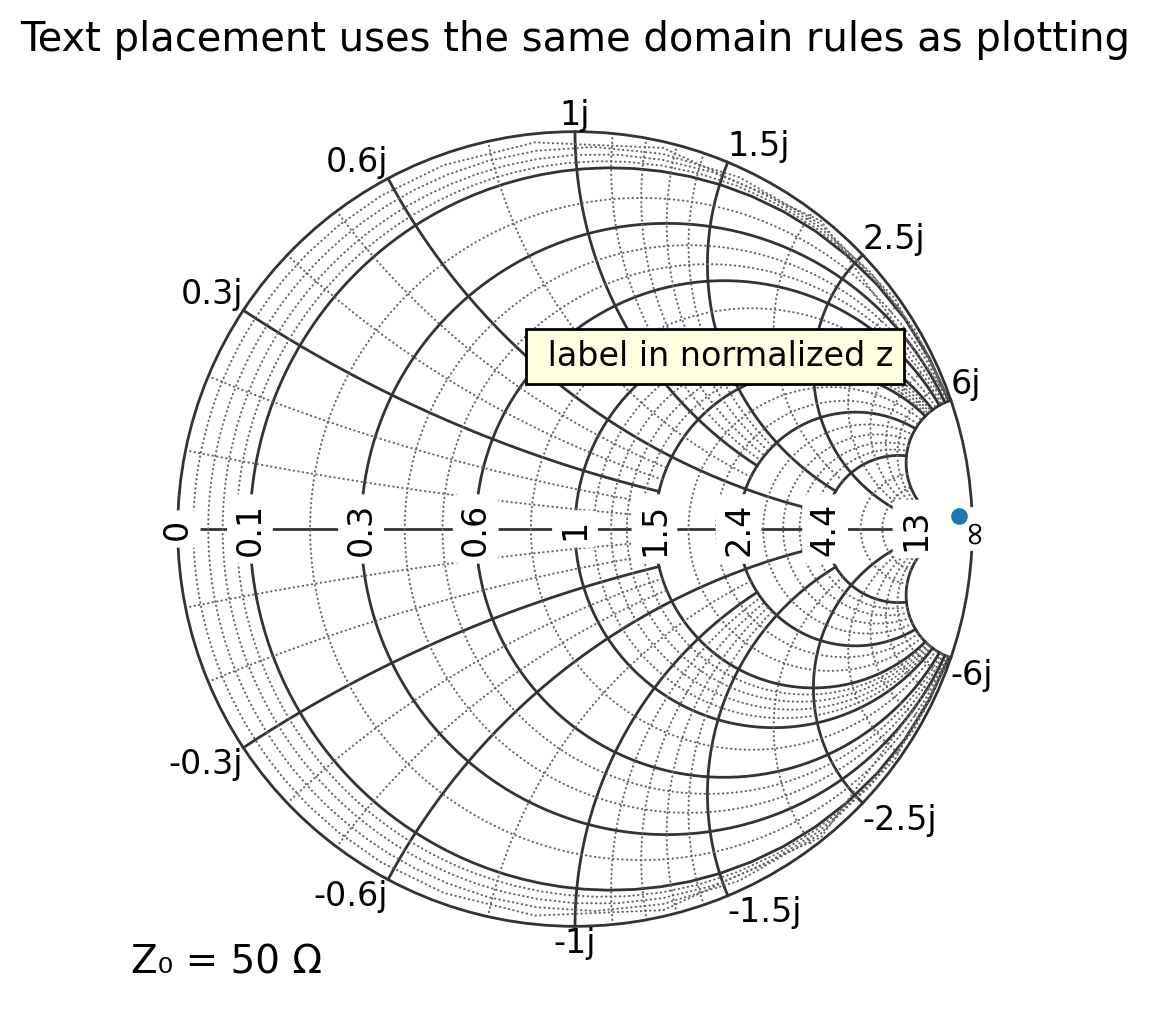

In [8]:
Z0 = 50
ZL = 30 + 1j * 30
z_norm = ZL / Z0

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=NORM_Z_DOMAIN)

ax.plot(ZL, marker="o", linestyle="")
ax.text(z_norm, " label in normalized z", bbox=text_box)

ax.set_title("Text placement uses the same domain rules as plotting")
plt.show()

### A simple example of ax.annotate()

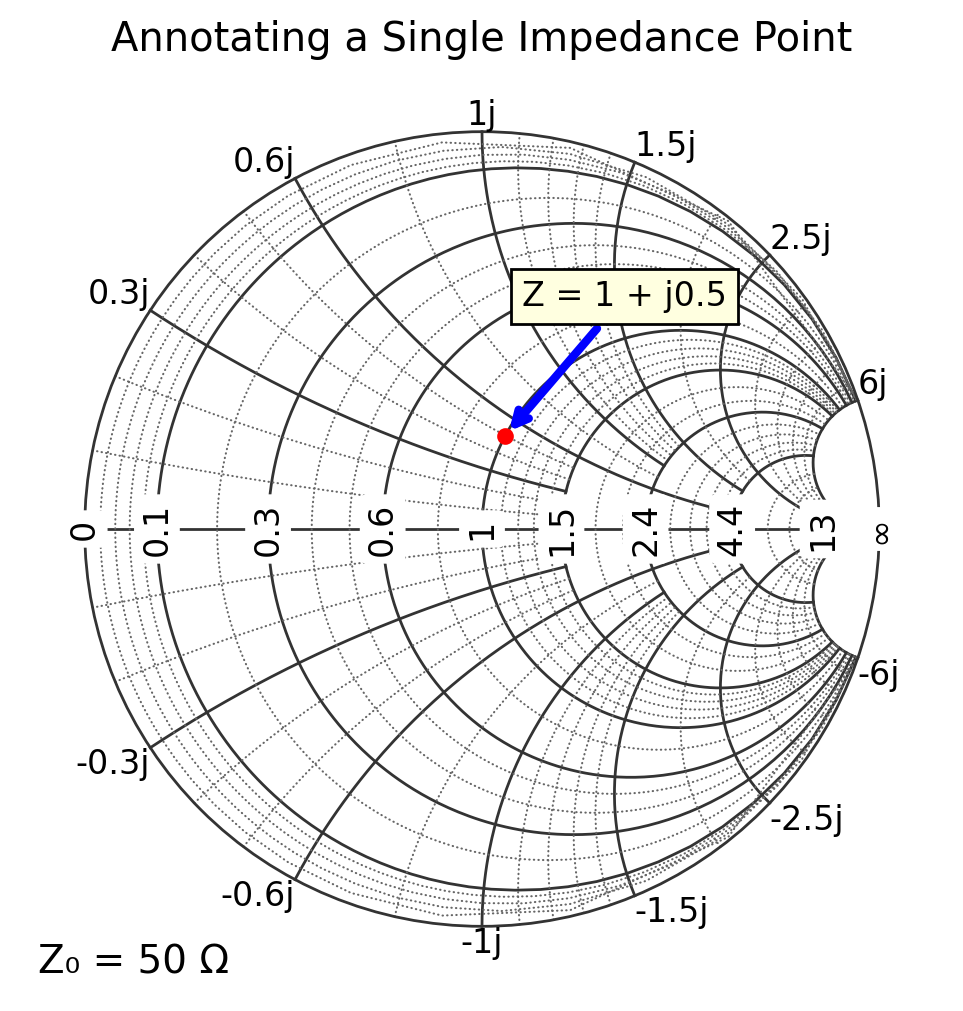

In [9]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=NORM_Z_DOMAIN)

z = 1 + 0.5j
ax.plot(z, "ro")

# Annotate the point
ax.annotate(
    "Z = 1 + j0.5",
    xy=(z.real, z.imag),  # point being annotated (Smith coords)
    xytext=(0.6, 1.0),  # location of text
    arrowprops=dict(arrowstyle="->", color="blue", lw=3),
    bbox=text_box,
)

ax.set_title("Annotating a Single Impedance Point")
plt.show()